### **PREPROCESSING - T WAVE ALTERNANS DETECTION USING SIGNAL PROCESSING AND A CONVOLUTIONAL NEURAL NETWORK**



By Pilar Aguilar
p.aguilar.2019@alumnos.urjc.es

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import splev, splrep
from scipy.io import loadmat
from scipy.signal import kaiserord, firwin, lfilter
import scipy.io as sio
import os
from scipy.io import loadmat
import random
import scipy
import json

# 1. Functions definition

In [ ]:
def background_subtraction(ST_T_ComplexTensor, WindSize):
    """
    This function performs the background subtraction of consecutive ST-T complexes.

    Parameters:
        ST_T_ComplexTensor (array): Tensor with windowed ST-T complexes. (3D array)
        WindSize (int): Size of the sliding window.

    Returns:
        ST_T_TensorBacGrElim (array): Tensor of windowed ST-T complexes after background subtraction.
    """

    # Create an array with the same shape as ST_T_ComplexTensor and fill it with zeros
    ST_T_TensorBacGrElim = np.zeros_like(ST_T_ComplexTensor)

    # Create a copy of the ST_T_ComplexTensor
    X = ST_T_ComplexTensor.copy()

    # Extract A pattern from X
    A_pattern = X[0::2, :]

    # Create an array with the same shape as A_pattern and fill it with zeros
    A_pattern_dis = np.zeros_like(A_pattern)

    # Assign values to A_pattern_dis by shifting A_pattern by one row
    A_pattern_dis[0:-1, :] = A_pattern[1:, :]
    A_pattern_dis[-1, :] = A_pattern[WindSize // 2 - 1, :]

    # Extract B pattern from X
    B_pattern = X[1::2, :]

    # Perform background subtraction by subtracting B_pattern from A_pattern rows and assigning the result to X
    X[0::2, :] = X[0::2, :] - B_pattern
    X[1::2, :] = X[1::2, :] - A_pattern_dis

    # Assign the modified X to ST_T_TensorBacGrElim
    ST_T_TensorBacGrElim = X

    # Return the resulting tensor after background subtraction
    return ST_T_TensorBacGrElim


In [ ]:
def bw_elimination(orig_ecg, fiducial_points, fs):
    """
    This function produces an estimate of the baseline wander using polynomial fitting by cubic splines.

    Parameters:
        orig_ecg (array): Samples of the original ECG.
        fiducial_points (array): Fiducial points.
        fs (float): Sampling frequency.

    Returns:
        bw_estimate (array): Baseline wander estimate.
    """

    # Define the duration before the fiducial point to consider as the isoelectric line (80 ms in this case)
    tPQ = 80e-3

    # Calculate the number of samples corresponding to the isoelectric line duration
    nPQ = int(tPQ * fs)

    # Get the number of fiducial points
    numb_fid_points = len(fiducial_points)

    if fiducial_points[0].any() - nPQ <= 0:
        # Create an array to store the knots for spline interpolation
        the_knots = np.array(np.zeros(numb_fid_points + 1))

        # Set the first knot to 1
        the_knots[0] = 1

        # Set the remaining knots as fiducial points minus the isoelectric line duration
        the_knots[1:numb_fid_points] = fiducial_points[1:numb_fid_points] - nPQ

        # Set the last knot as the length of the original ECG
        the_knots[numb_fid_points] = len(orig_ecg)

        # Convert the knots to indices (subtract 1 to account for zero-based indexing)
        the_knots = the_knots - 1
        the_knots = the_knots.astype(int)

        # Create an array 'c' to specify the continuity of the splines
        c = np.concatenate((the_knots[1], the_knots[1:numb_fid_points], the_knots[numb_fid_points-1]), axis=None)

        # Perform cubic spline interpolation using the knots and original ECG samples
        bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots, orig_ecg[c]), ext=0)

    else:
        # Create an array to store the knots for spline interpolation
        the_knots = np.array(np.zeros(numb_fid_points + 2))

        # Set the first knot to 1
        the_knots[0] = 1

        # Set the remaining knots as fiducial points minus the isoelectric line duration
        the_knots[1:numb_fid_points] = fiducial_points - nPQ

        # Set the last knot as the length of the original ECG
        the_knots[numb_fid_points] = len(orig_ecg)

        # Convert the knots to indices (subtract 1 to account for zero-based indexing)
        the_knots = the_knots - 1
        the_knots = the_knots.astype(int)

        # Create an array 'c' to specify the continuity of the splines
        c = np.concatenate((the_knots[1], the_knots[1:numb_fid_points], the_knots[numb_fid_points-1]), axis=None)

        # Perform cubic spline interpolation using the knots and fiducial points
        bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots, c), ext=0)

    # Return the estimated baseline wander
    return bw_estimate

In [ ]:
def filtering_ST_T_segments(ST_T_ComplexTensor, Fs):
    """
    This function filters out the ST-T complexes to eliminate noise outside the TWA band (0.3-15 Hz).

    Parameters:
        ST_T_ComplexTensor (array): Tensor with windowed ST-T complexes.
        Fs (float): Working sampling frequency.

    Returns:
        ST_T_TensorFiltered (array): Tensor of windowed ST-T complexes after filtering.
    """

    # Design the filter
    nyquist = 0.5 * Fs
    passband_low = 0.3
    passband_high = 15.0
    ripple_db = 0.01
    ripple = 80.0

    # obtain numtaps and beta using kaiserord
    numtaps, beta = kaiserord(ripple, (passband_high - passband_low) / nyquist)

    # Compute the normalized cutoff frequencies
    cutoff_low = passband_low / nyquist
    cutoff_high = passband_high / nyquist

    # Compute the filter coefficients using firwin
    b = firwin(numtaps, [cutoff_low, cutoff_high], window=('kaiser', beta), pass_zero=False, scale=False)
    delay = int((numtaps + 1) / 2)
    b_wide = b

    # Initialize the filtered tensor
    ST_T_TensorFiltered = np.zeros_like(ST_T_ComplexTensor)

    # Iterate over segments, windows, and ST-T samples
    for k1 in range(ST_T_ComplexTensor.shape[2]):
        for k2 in range(ST_T_ComplexTensor.shape[0]):
            # Apply filtering to each window
            filtered_wide = lfilter(b_wide, 1, np.concatenate((ST_T_ComplexTensor[k2, :, k1], np.zeros(delay))))
            ST_T_TensorFiltered[k2, :, k1] = filtered_wide[delay:ST_T_ComplexTensor.shape[1] + delay]

    return ST_T_TensorFiltered


In [ ]:
def heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep):
    """
    This function performs windowing to track alternans in an ECG.

    Parameters:
        ST_T_complexes (array): 2D matrix of ST-T segments of the signal.
        ST_T_onset (array): Onset of the ST-T segments.
        WindSize (int): Window length in beats.
        WindStep (int): Step size of the sliding process.

    Returns:
        ST_T_segments (array): Tensor with windowed ST-T complexes.
        ST_T_onset_by_segments (array): ST-T onset of the tensor.
        ST_T_dim (tuple): Dimensions of the incoming matrix of ST-T complexes.
    """

    Overlap = WindSize - WindStep
    ST_T_dim = np.shape(ST_T_complexes)

    NumbSegments = int((ST_T_dim[0] - Overlap) / WindStep)

    # Adjust the number of segments if necessary
    if NumbSegments == np.ceil((ST_T_dim[0] - Overlap) / WindStep):
        NumbSegments = NumbSegments - 1

    # Initialize tensors to store windowed ST-T complexes and ST-T onsets
    ST_T_segments = np.zeros((WindSize, ST_T_dim[1], NumbSegments))
    ST_T_onset_by_segments = np.zeros((NumbSegments, WindSize))

    index1 = 0
    index2 = WindSize

    # Perform windowing
    for k in range(NumbSegments):
        ST_T_segments[:, :, k] = ST_T_complexes[index1:index2, :]
        ST_T_onset_by_segments[k, :] = ST_T_onset[index1:index2]
        index1 = index1 + WindStep
        index2 = index2 + WindStep

    return ST_T_segments, ST_T_onset_by_segments, ST_T_dim

In [ ]:
def np_round(a, decimals=0):
    return np.round(a * 10 ** decimals) / 10 ** decimals


def ST_T_alignment(ST_T_complexes, ST_T_onset, ecg_signal, fs):
"""
    This function performs ST-T complex alignment using cross-correlation.

    Parameters:
        ST_T_complexes (array): 2D matrix of ST-T complexes.
        ST_T_onset (array): Onset of the ST-T complexes.
        ecg_signal (array): ECG signal.
        fs (float): Sampling frequency of the ECG signal.

    Returns:
        ST_T_complexes_align (array): Aligned ST-T complexes.
    """

    nbeats, nsamples = ST_T_complexes.shape
    ST_T_complexes_align = np.zeros(ST_T_complexes.shape)

    # Median template
    proto = np.median(ST_T_complexes, axis=0)

    # Calculate possible temporal variation from the initial position of each ST-T complex
    w = (0.03 * fs)  # samples
    w = np_round(w)
    w = int(w)

    for k in range(nbeats):
        ini = int(ST_T_onset[k])
        fin = int(ini + nsamples - 1)

        ecg_segment = ecg_signal[ini - w:fin + w]
        cross_corr = np.zeros(2 * w)

        for m in range(2 * w):
            temp = ecg_segment[m:-(2 * w) + m]
            # Adjust the dimension of temp if necessary
            if temp.shape[0] < proto.shape[0]:
                temp = np.append(temp, temp[-1])
            cc = np.corrcoef(proto, temp)
            cross_corr[m] = cc[1, 0]

        posMax = np.argmax(cross_corr)
        ST_T_complexes_align[k, :] = ecg_segment[posMax:posMax + nsamples]

    return ST_T_complexes_align

In [ ]:
def ST_T_delineation(ecg_signal, fiducial_points, fs):
    """
    This function delineates the ST-T complex using intervals of 300 ms length.
    The ST-T onset is chosen to be a variable distance from the QRS point that
    depends on the previous RR interval length.

    Parameters:
        ecg_signal (array): ECG signal.
        fiducial_points (array): R wave annotations.
        fs (float): Sampling frequency.

    Returns:
        ST_T_complexes (array): Matrix of ST-T complexes.
        ST_T_onset (array): Array of annotations of ST-T onset values.
    """

    RR_interval = np.diff(fiducial_points) / fs  # RR interval in seconds
    qi = 40 + (1.3 * np.sqrt(RR_interval * 1e3))  # ST-T onset from R in milliseconds

    # Handle different dimensions of qi array
    if qi.ndim == 1:
        qi = np.column_stack((qi[0], qi[:-1]))
    else:
        qi = np.column_stack((qi[:, 0], qi[:, :-1]))

    s = np.array(qi * 1e-3 * fs)
    fiducial_points = fiducial_points.transpose()

    ST_T_onset = fiducial_points + np.ceil(s) + 1  # ST-T onset in samples

    # Convert ST_T_onset to a list with individual values
    ST_T_onset = [matriz[0] for matriz in ST_T_onset]

    ST_T_interval = np.ceil(300e-3 * fs)  # ST-T interval length in number of samples

    ST_T_complexes = np.zeros((len(ST_T_onset)-1, int(ST_T_interval)))
    last_beat = ST_T_onset[-1]

    number_of_ST_T = len(ST_T_onset)
    for k in range(number_of_ST_T - 1):
        onset = int(np.ceil(ST_T_onset[k]))
        interval = onset + ST_T_interval

        if interval <= len(ecg_signal):
            # Ensure the start and end indices are within the array bounds
            onset_index = int(onset)
            interval_index = min(int(interval), len(ecg_signal))
            ST_T_complexes[k, :] = ecg_signal[onset_index:interval_index]

    return ST_T_complexes, ST_T_onset


In [ ]:
def include_TWA(clean_ecg, ST_T_onset, Alternan_wave, TWA_pattern, Type_of_inclusion):
    """
    The purpose of this function is the inclusion of an alternan wave into an ECG signal.

    Parameters:
        clean_ecg (numpy array): Array of integers corresponding to the ECG signal.
        ST_T_onset (numpy array): Array of annotations of ST-T onset values.
        Alternan_wave (numpy array): Waveform to perform TWA.
        TWA_pattern (numpy array): Array that describes the intervals where TWA are included.
        Type_of_inclusion (str): If this string is 'alternate', the alternan wave is included in every other beats with opposite sign.
                                 Otherwise, the alternan wave is only included every two beats.

    Returns:
        ecg_with_TWA (numpy array): ECG with TWA.
        Alt_waves (numpy array): Matrix whose rows consist of the alternan waves of ecg_with_TWA. It is subsequently used to compute the ANR.
    """

    # Get the length of the Alternan wave
    L_AltWav = len(Alternan_wave)

    # Create a copy of the clean ECG signal
    ecg_with_TWA = clean_ecg.copy()

    # Initialize the Alt_waves matrix
    Alt_waves = np.zeros((len(ST_T_onset), L_AltWav))

    if Type_of_inclusion.lower() == 'alternate':
        # Include alternan wave in every other beat with opposite sign
        for k, onset in enumerate(ST_T_onset):
            if onset + L_AltWav <= (clean_ecg.shape[1]):
                Alt_waves[k, :] = TWA_pattern[k] * Alternan_wave * (-1) ** k
                #plt.plot(ecg_with_TWA[0, onset:onset + L_AltWav])
                ecg_with_TWA[0, onset:onset + L_AltWav] += Alt_waves[k, :]
                #plt.plot(ecg_with_TWA[0, onset:onset + L_AltWav])
                #plt.show()


    else:
        # Include alternan wave every two beats
        for k, onset in enumerate(ST_T_onset[1::2]):
            if onset + L_AltWav <= (clean_ecg.shape[1]):
                Alt_waves[k, :] = TWA_pattern[2 * k] * Alternan_wave
                ecg_with_TWA[0, onset:onset + L_AltWav] += Alt_waves[k, :]
    return ecg_with_TWA, Alt_waves


In [ ]:
def alternant_wave_inclusion(clean_ecg, TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, Fs):
    """
    This function introduces an alternant wave according to the pattern
    defined by 'TWA_pattern' in the signal 'clean_ecg'.

    Input parameters:
        - clean_ecg: annotations of the R wave.
        - TWA_pattern: TWA pattern vector.
        - type_of_inclusion: manner TWA is included; can be 'alternate' or not.
        - ST_T_onset: onset of ST-T complexes of the ECG.
        - V_Alt_wave: alternant voltage.
        - Fs: sampling frequency

    Output parameters:
        - ecg_with_TWA: ECG signal with alternans.
        - Alt_waves: matrix whose rows consist of the alternan wave ecg_with_TWA.
        - Alternan_wave: waveform to perform TWA.
        - Onset_Valt: onset of TWA inclusion, having considered Jitter effect.
    """

    # Load the MATLAB file
    mat_data = scipy.io.loadmat('AltWav_128hz.mat')

    AltWav = np.random.randint(1, 16)

    # Access the desired key
    Alternan_wave = mat_data['AltWav_128hz'][:, AltWav - 1]

    if type_of_inclusion.lower() == 'alternate':
        alpha = V_Alt_wave / (np.max(np.abs(2 * Alternan_wave)) * 1e3)
    else:
        alpha = V_Alt_wave / (np.max(np.abs(Alternan_wave)) * 1e3)

    jitter_std = int(0.02 * Fs)  # Jitter effect standard deviation of 20 ms (0.02*Fs samples)

    Onset_Valt = (ST_T_onset + np.round(np.random.randn(len(ST_T_onset)) * jitter_std)).astype(int)

    # Perform TWA inclusion using the include_TWA function
    ecg_with_TWA, Alt_waves = include_TWA(clean_ecg, Onset_Valt, alpha * Alternan_wave, TWA_pattern, type_of_inclusion)

    V0 = np.max(np.abs(alpha * Alternan_wave)) * 1e3  # Alternan wave amplitude in microvolts
    if type_of_inclusion.lower() == 'alternate':
        V0 = 2 * V0

    return ecg_with_TWA, Alt_waves, Alternan_wave, alpha, Onset_Valt

# 2. Preprocessing

## 2.2.All signals

In this case, the code is importing the drive module from google.colab to enable Google Drive integration within the Colaboratory environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Ruta de la carpeta en Drive
carpeta_drive = '/content/drive/MyDrive/Señales_sin_alternancias'

# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta_drive)
# las mezclamos para que no este ordenada por pacientes
archivos = random.sample(archivos, len(archivos))
print("Number of signals:" , len(archivos))

206


### 2.2.1 Obtain the fetaures to add alternance

In [ ]:
all_with_TWA = []   # List to store ECG signals with alternans
all_segments = {}   # Dictionary to store segments

# Iterate over each file
for archivo in archivos:
    # Build the full file path
    ruta_archivo = os.path.join(carpeta_drive, archivo)
    print(ruta_archivo)

    # Check if it is a file
    if os.path.isfile(ruta_archivo):
        if archivo.endswith('.mat'):
            # Load the .mat file
            signal = loadmat(ruta_archivo)

            # Access the data in the file
            Fs = signal['Fs']
            ecg = signal['ecg']
            qrs = signal['qrs']
            QRS_ann = signal['qrs_ann']

            # 1. We need ST_T_onset: obtained from preprocessing steps 1 and 2

            # Step 1: Baseline wandering elimination
            bw_estimate_clean = bw_elimination(ecg[0, :], qrs[0, :], Fs)
            clean_ecg_noBW = ecg[0, :] - bw_estimate_clean + np.mean(bw_estimate_clean)

            # Step 2: ST-T complex segmentation (where alternans will be searched)
            ST_T_complexes, ST_T_onset = ST_T_delineation(clean_ecg_noBW, qrs, Fs)

            # 2. We can extract alternans

            # Input parameters
            clean_ecg = ecg
            TWA_pattern = np.ones(qrs.shape[1])
            type_of_inclusion = 'alternate'
            V_Alt_wave = 35  # muV

            # Alternans inclusion
            ecg_with_TWA, alt_waves, Alternan_wave, alpha, Onset_Valt = alternant_wave_inclusion(
                clean_ecg, TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, Fs
            )

            # Append ECG signal with alternans to the list
            all_with_TWA.append(ecg_with_TWA)

NameError: ignored

2.2.2 Create a list with all signals

In [ ]:
import os
from scipy.io import loadmat

from google.colab import drive
drive.mount('/content/drive')
# Ruta de la carpeta en Drive
carpeta_drive = '/content/drive/MyDrive/Señales_sin_alternancias'

# Obtain the list of files
archivos = os.listdir(carpeta_drive)
# mix
archivos = random.sample(archivos, len(archivos))
print(archivos)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['nsrdb_16420_l2_s11.mat', 'nsrdb_16265_l1_s22.mat', 'nsrdb_16539_l1_s3.mat', 'nsrdb_16265_l1_s28.mat', 'nsrdb_16539_l1_s22.mat', 'nsrdb_16483_l1_s17.mat', 'nsrdb_16539_l1_s37.mat', 'nsrdb_16539_l1_s33.mat', 'nsrdb_16539_l1_s35.mat', 'nsrdb_16483_l1_s14.mat', 'nsrdb_16265_l1_s24.mat', 'nsrdb_16265_l1_s3.mat', 'nsrdb_16420_l1_s31.mat', 'nsrdb_16483_l1_s22.mat', 'nsrdb_16539_l1_s28.mat', 'nsrdb_16786_l1_s20.mat', 'nsrdb_16265_l1_s7.mat', 'nsrdb_16273_l2_s15.mat', 'nsrdb_16265_l1_s32.mat', 'nsrdb_16265_l2_s5.mat', 'nsrdb_16265_l2_s6.mat', 'nsrdb_16273_l2_s21.mat', 'nsrdb_16420_l1_s11.mat', 'nsrdb_16483_l1_s18.mat', 'nsrdb_16420_l2_s20.mat', 'nsrdb_16265_l1_s6.mat', 'nsrdb_16483_l2_s1.mat', 'nsrdb_16539_l2_s22.mat', 'nsrdb_16539_l1_s4.mat', 'nsrdb_16539_l1_s18.mat', 'nsrdb_16273_l2_s29.mat', 'nsrdb_16483_l1_s8.mat', 'nsrdb_16420_l1_s24.mat', 'nsrdb_16265_l1_s25.m

###  2.2.3 Obtain the features fro adding alternance

In [ ]:
# Create a dictionary to store the data
data_dict = {}

# Iterate over each file
for archivo in archivos:
    # Build the full file path
    ruta_archivo = os.path.join(carpeta_drive, archivo)
    print(ruta_archivo)

    # Check if it is a file
    if os.path.isfile(ruta_archivo):
        if archivo.endswith('.mat'):
            # Load the .mat file
            signal = loadmat(ruta_archivo)

            # Access the data contained in the file

            # Preprocessing steps
            Fs = signal['Fs']
            ecg = signal['ecg']
            qrs = signal['qrs']
            QRS_ann = signal['qrs_ann']

            # Obtain ST_T_onset for alternans extraction

            # Step 1: Baseline wandering elimination
            bw_estimate_clean = bw_elimination(ecg[0, :], qrs[0, :], Fs)
            clean_ecg_noBW = ecg[0, :] - bw_estimate_clean + np.mean(bw_estimate_clean)

            # Step 2: ST-T complex segmentation (where alternans will be searched)
            ST_T_complexes, ST_T_onset = ST_T_delineation(clean_ecg_noBW, qrs, Fs)

            # Associate the data with the corresponding file in the dictionary
            data_dict[archivo] = {
                'ecg': ecg,
                'ST_T_onset': ST_T_onset,
                'qrs': qrs,
                'qrs_ann': QRS_ann
            }


/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16420_l2_s11.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16265_l1_s22.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16539_l1_s3.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16265_l1_s28.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16539_l1_s22.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16483_l1_s17.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16539_l1_s37.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16539_l1_s33.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16539_l1_s35.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16483_l1_s14.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16265_l1_s24.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16265_l1_s3.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16420_l1_s31.mat
/content/drive/MyDrive/Señales_sin_alternancias/nsrdb_16483_l1_s22.mat
/content

###  2.2.4 Add alternans to half of the signals

In [ ]:
# Create a dictionary to store signals with alternans
signals_with_alternans = {}

# Calculate the number of signals to iterate (half of the dataset)
half_dataset_size = len(data_dict) // 2

# Get the keys corresponding to the first half of the dictionary
half_keys = list(data_dict.keys())[:half_dataset_size]

# Set input parameters
type_of_inclusion = 'alternate'
V_Alt_wave = 35  # muV
Fs = 128  # Hz

# Iterate over the keys
for key in half_keys:
    signal = data_dict[key]['ecg']

    # Obtain the 'TWA_pattern' and 'ST_T_onset' corresponding to the current signal
    TWA_pattern = np.ones(data_dict[key]['qrs'].shape[1])
    ST_T_onset = data_dict[key]['ST_T_onset']
    QRS_ann = data_dict[key]['qrs_ann']
    qrs = data_dict[key]['qrs']

    # Generate the new signal with alternans using the 'alternant_wave_inclusion' function
    ecg_with_TWA, alt_waves, Alternan_wave, alpha, Onset_Valt = alternant_wave_inclusion(
        signal, TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, Fs
    )

    # Convert the list to a NumPy array
    st_t_onset_array = np.array(ST_T_onset)

    # Add the new signal to the dictionary of signals with alternans
    signals_with_alternans[key] = {
        'ecg': ecg_with_TWA,
        'ST_T_onset': st_t_onset_array,
        'qrs': qrs,
        'qrs_ann': QRS_ann,
        'label': 1
    }

1
1120
1
2352
1
688
1
2496
1
512
1
1968
1
464
1
2048
1
1168
1
656
1
1072
1
3824
1
528
1
1232
1
1840
1
3184
1
3184
1
2640
1
2400
1
5584
1
1776
1
848
1
976
1
1216
1
784
1
1952
1
1343
1
3872
1
448
1
656
1
624
1
1648
1
6544
1
2048
1
912
1
992
1
784
1
384
1
624
1
880
1
6432
1
7136
1
496
1
1456
1
527
1
864
1
2864
1
400
1
2224
1
3855
1
1152
1
1456
1
496
1
1536
1
736
1
688
1
544
1
12736
1
2176
1
12656
1
1312
1
624
1
2000
1
1248
1
1248
1
1040
1
8575
1
3008
1
2656
1
400
1
640
1
720
1
448
1
3792
1
944
1
6048
1
1920
1
6704
1
464
1
416
1
5728
1
1216
1
3712
1
1456
1
1552
1
2288
1
800
1
1376
1
3679
1
2400
1
1840
1
976
1
1519
1
3424
1
2352
1
2448
1
2592
1
2896
1
592
1
688
1
2464
1
1296
1
768


###  2.2.5 Create a dictionary with the signals without alternans

In [ ]:
# Calculate the number of signals for which TWA was not added
half_dataset_size = len(data_dict) // 2
print(half_dataset_size)

# Get the keys corresponding to the second half of the dictionary
half_keys = list(data_dict.keys())[half_dataset_size:]

# Create a dictionary to store signals without TWA
signals_no_TWA = {key: data_dict[key] for key in half_keys}

# Print the keys of signals with and without TWA
print("TWA signals:", signals_with_alternans.keys())
print("No TWA signals:", signals_no_TWA.keys())


103
dict_keys(['nsrdb_16483_l2_s34.mat', 'nsrdb_16420_l2_s3.mat', 'nsrdb_16483_l2_s8.mat', 'nsrdb_16539_l1_s13.mat', 'nsrdb_16420_l2_s7.mat', 'nsrdb_16265_l1_s35.mat', 'nsrdb_16539_l2_s21.mat', 'nsrdb_16483_l1_s27.mat', 'nsrdb_16539_l1_s46.mat', 'nsrdb_16273_l2_s40.mat', 'nsrdb_16265_l1_s29.mat', 'nsrdb_16539_l1_s51.mat', 'nsrdb_16483_l2_s3.mat', 'nsrdb_16483_l1_s11.mat', 'nsrdb_16420_l1_s20.mat', 'nsrdb_16539_l1_s24.mat', 'nsrdb_16273_l2_s7.mat', 'nsrdb_16786_l1_s11.mat', 'nsrdb_16539_l2_s28.mat', 'nsrdb_16483_l2_s21.mat', 'nsrdb_16483_l1_s35.mat', 'nsrdb_16265_l2_s1.mat', 'nsrdb_16483_l1_s29.mat', 'nsrdb_16265_l2_s14.mat', 'nsrdb_16265_l1_s4.mat', 'nsrdb_16420_l1_s5.mat', 'nsrdb_16420_l1_s23.mat', 'nsrdb_16265_l1_s13.mat', 'nsrdb_16539_l1_s1.mat', 'nsrdb_16483_l2_s25.mat', 'nsrdb_16539_l1_s15.mat', 'nsrdb_16483_l2_s32.mat', 'nsrdb_16483_l1_s34.mat', 'nsrdb_16265_l2_s7.mat', 'nsrdb_16420_l1_s30.mat', 'nsrdb_16265_l1_s20.mat', 'nsrdb_16420_l1_s10.mat', 'nsrdb_16483_l1_s7.mat', 'nsrdb_1

Label with 0s

In [ ]:
for key in signals_no_TWA:
    signals_no_TWA[key]['label'] = 0
#print(len(signals_no_TWA['nsrdb_16420_l1_s26.mat']['ST_T_onset']))

Combine both dictionaries

In [ ]:
# Combine signals with alternans and without alternans
merged_dict = {**signals_with_alternans, **signals_no_TWA}
print(len(merged_dict.keys()))

206


###  2.2.6. START THE PREPROCESSING

1. Base line wandering elimination
2. ST-T complex segmentation
3. Windowing
4. ST-T segment aligment
5. Backgroung substraction
6. Filtering

In [ ]:
all_filtered_FINAL = {}

# Iterate over each key in the merged_dict
for key in merged_dict:
    signal = merged_dict[key]['ecg']
    qrs = merged_dict[key]['qrs']
    print(key)

    # Preprocessing
    ecg = signal
    # 1. Base line wandering elimination
    bw_estimate_clean = bw_elimination(ecg[0, :], qrs[0, :], Fs)
    clean_ecg_noBW = ecg[0, :] - bw_estimate_clean + np.mean(bw_estimate_clean)

    # 2. ST-T complex segmentation
    ST_T_complexes, ST_T_onset = ST_T_delineation(clean_ecg_noBW, qrs, Fs)

    # 3. Windowing
    WindSize = 32  # Analyze in blocks of 32 beats
    WindStep = 8   # Each window contains 8 new beats
    ST_T_segments, ST_T_onset_by_segments, _ = heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep)

    # 4. ST-T segment alignment
    WindSize = 32
    NumbSegments = ST_T_segments.shape[2]

    # Step 1: Create an array of zeros to store the aligned ST-T segments
    ST_T_segments_aligned = np.zeros((WindSize, ST_T_segments.shape[1], NumbSegments))

    # Step 2: Iterate over each segment
    for k in range(NumbSegments):
        # Step 3: Align the ST-T segment using ST_T_alignment function
        aligned_segment = ST_T_alignment(ST_T_segments[:, :, k], ST_T_onset_by_segments[k, :], clean_ecg_noBW, Fs)

        # Step 4: Store the aligned segment in the corresponding position of ST_T_segments_aligned
        ST_T_segments_aligned[:, :, k] = aligned_segment

    # 5. Background Subtraction
    WindSize = 32
    NumbSegments = ST_T_segments_aligned.shape[2]
    ST_T_dif = np.zeros_like(ST_T_segments_aligned)

    for k in range(NumbSegments - 1):
        # Perform background subtraction using background_subtraction function
        ST_T_TensorBacGrElim = background_subtraction(ST_T_segments_aligned[:, :, k], WindSize)

        # Store the result in the ST_T_dif array
        ST_T_dif[:, :, k] = ST_T_TensorBacGrElim

    # 6. Filtering
    fs = 128
    ST_T_dif_filtered = filtering_ST_T_segments(ST_T_dif, fs)

    segmentos = {}
    for k in range(NumbSegments):
        # Store the filtered segments in a dictionary
        segmentos[k] = ST_T_dif_filtered[:, :, k]

    # Store the segments dictionary in the final filtered dictionary using the key
    all_filtered_FINAL[key] = segmentos


nsrdb_16420_l2_s11.mat
nsrdb_16265_l1_s22.mat
nsrdb_16539_l1_s3.mat
nsrdb_16265_l1_s28.mat
nsrdb_16539_l1_s22.mat
nsrdb_16483_l1_s17.mat
nsrdb_16539_l1_s37.mat
nsrdb_16539_l1_s33.mat
nsrdb_16539_l1_s35.mat
nsrdb_16483_l1_s14.mat
nsrdb_16265_l1_s24.mat
nsrdb_16265_l1_s3.mat
nsrdb_16420_l1_s31.mat
nsrdb_16483_l1_s22.mat
nsrdb_16539_l1_s28.mat
nsrdb_16786_l1_s20.mat
nsrdb_16265_l1_s7.mat
nsrdb_16273_l2_s15.mat
nsrdb_16265_l1_s32.mat
nsrdb_16265_l2_s5.mat
nsrdb_16265_l2_s6.mat
nsrdb_16273_l2_s21.mat
nsrdb_16420_l1_s11.mat
nsrdb_16483_l1_s18.mat
nsrdb_16420_l2_s20.mat
nsrdb_16265_l1_s6.mat
nsrdb_16483_l2_s1.mat
nsrdb_16539_l2_s22.mat
nsrdb_16539_l1_s4.mat
nsrdb_16539_l1_s18.mat
nsrdb_16273_l2_s29.mat
nsrdb_16483_l1_s8.mat
nsrdb_16420_l1_s24.mat
nsrdb_16265_l1_s25.mat
nsrdb_16420_l1_s34.mat
nsrdb_16539_l2_s5.mat
nsrdb_16420_l1_s3.mat
nsrdb_16539_l1_s41.mat
nsrdb_16273_l2_s10.mat
nsrdb_16420_l1_s15.mat
nsrdb_16273_l2_s14.mat
nsrdb_16265_l2_s10.mat
nsrdb_16483_l2_s7.mat
nsrdb_16420_l1_s8.mat
n

###  2.2.7. Store the preprocessed signals

In [ ]:
ruta_archivo = "/content/drive/MyDrive/Post-Procesado/DICTIONARYPILAR.json"

In [ ]:
# Function to recursively convert NumPy arrays to lists
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: numpy_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(v) for v in obj]
    else:
        return obj

# Save the all_filtered_FINAL dictionary as JSON
with open(ruta_archivo, "w") as archivo:
    json.dump(numpy_to_list(all_filtered_FINAL), archivo)

# Load the JSON data back into a dictionary
with open(ruta_archivo, "r") as archivo:
    datos_cargados = json.load(archivo)

    datos_cargados = json.load(archivo)

In [ ]:
# the preprocessed data to avoid repeating the preprocessing steps
# Convert the list to a NumPy array
all_filtered_array = np.array(all_filtered)

# Save the array to a file
np.save('preprocessed_data.npy', all_filtered_array)


In [ ]:
print("We have a total of :", all_filtered_array.shape(), "signals stored in the json file")

In order to follow the path of the bachelor thesis, the notebook number 2 attached in ...., develops a convolutional network that allows the detection of the T wave.

## 2.1. Only one signal

### 2.2.1. Load ecg and get to know our data

In [ ]:
# Load the .mat file
data = loadmat('/content/nsrdb_16265_l1_s10.mat')


NameError: ignored

### 2.1.2. Obtain the features

In [ ]:
# Print all the feature names
feature_names = data.keys()
for name in feature_names:
    print(name)

In [ ]:
ecg = data['ecg']
print(ecg)

[[ 2.455  2.875  2.715 ... -0.555  1.475  2.805]]


In [ ]:
qrs = data['qrs']
#print(qrs)
print(qrs.shape)

(1, 496)


In [ ]:
QRS_ann = data['qrs_ann']
print(QRS_ann)

len(QRS_ann)

['NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNFNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN']


1

In [ ]:
Fs = data['Fs']
ts = 1/Fs
print(Fs)

[[128]]


### 2.1.3. Add alternance

(1, 496)


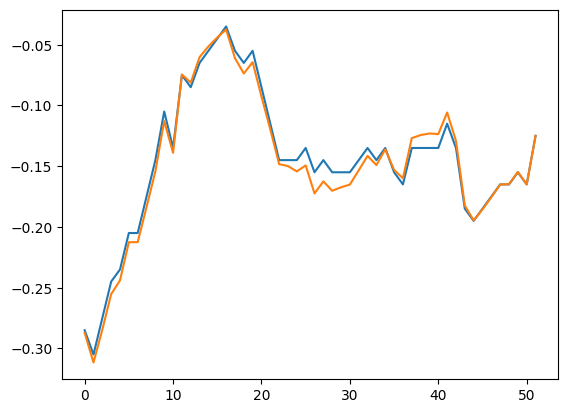

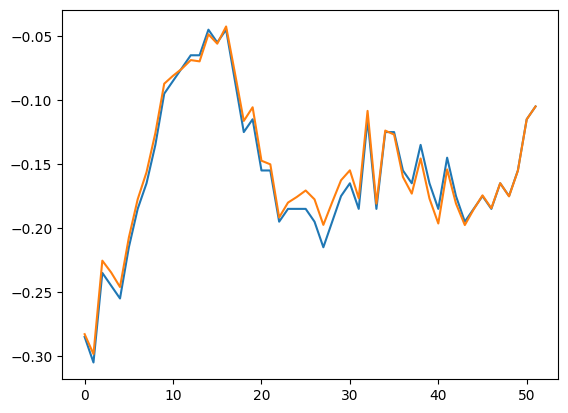

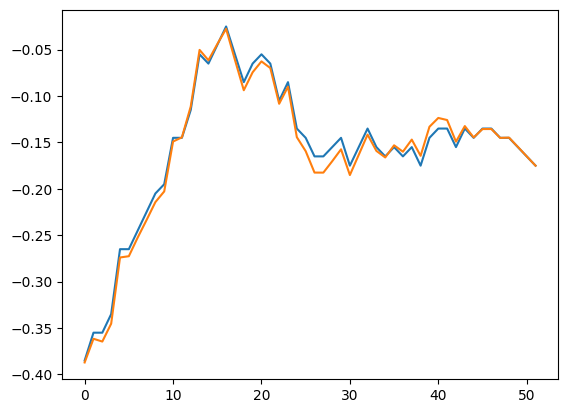

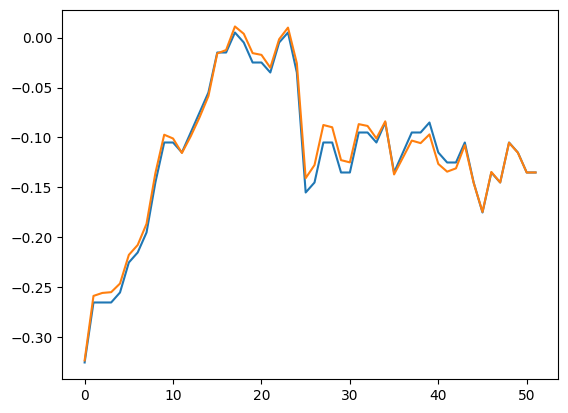

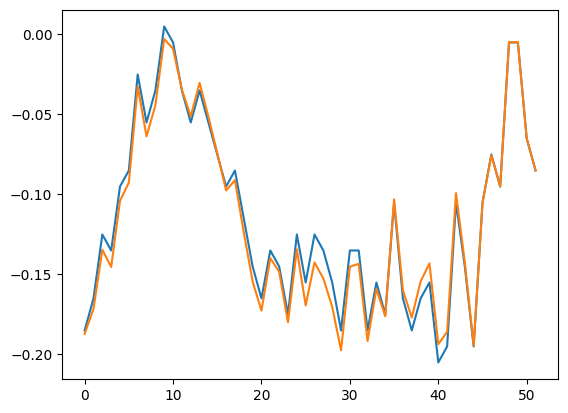

KeyboardInterrupt: ignored

In [ ]:
#input parameters
import matplotlib.pyplot as plt
import scipy
clean_ecg = ecg
TWA_pattern = np.ones(qrs.shape[1])
print(qrs.shape)
type_of_inclusion = 'alternate'
V_Alt_wave = 35  # muV

#alternance inclusion
ecg_with_TWA, alt_waves, Alternan_wave, alpha, Onset_Valt = alternant_wave_inclusion(clean_ecg, TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, Fs)
print(ecg_with_TWA)

In [ ]:
plt.plot(ecg_with_TWA[0,:])
plt.xlim(0, 500)
plt.show()
print(ecg_with_TWA)

### 2.1.4. PREPROCESSING

### 2.1.- Base line wandering elimination

In [ ]:
# 1. Base line wandering elimination
bw_estimate_clean = bw_elimination(ecg[0,:], qrs[0,:], Fs)
clean_ecg_noBW = ecg[0,:] - bw_estimate_clean + np.mean(bw_estimate_clean)

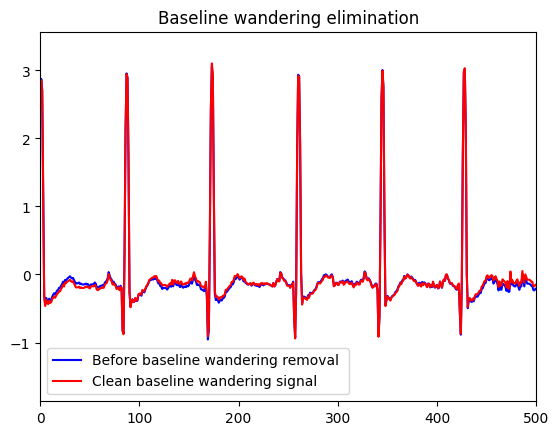

In [ ]:
plt.figure()
plt.plot(ecg2[0, :], color='blue', label='Before baseline wandering removal ')
plt.plot(clean_ecg_noBW, color='red', label='Clean baseline wandering signal')
plt.xlim(0, 500)
plt.title('Baseline wandering elimination')
plt.legend()
plt.show()

### 2.2.-  ST-T complexes segmentation

In [ ]:
# 2. Segmentación de los complejos ST-T (es ahí donde se buscará la alternancia)
ST_T_complexes, ST_T_onset = ST_T_delineation(clean_ecg_noBW, qrs, Fs)


In [ ]:
print(ST_T_complexes.shape)
#ST_T_complexes is a matrix of 496 ST-T complexes, each with 39 samples within the 300 ms interval.

(495, 39)


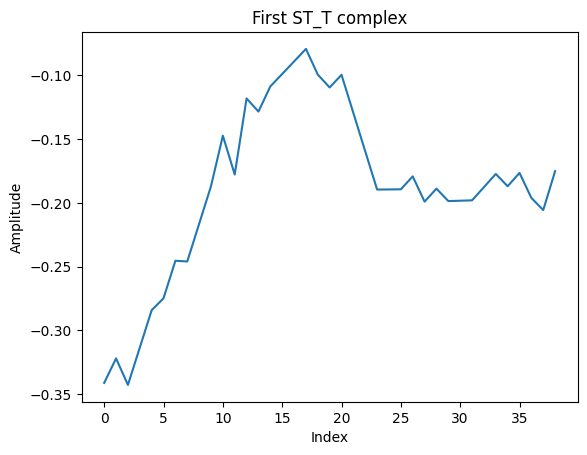

In [ ]:
#transpose ST_T_complexes

ST_T_complexes_transpose = np.transpose(ST_T_complexes)

#print the first complex
plt.plot(ST_T_complexes_transpose[:,0])

plt.xlabel('Index')
plt.ylabel('Amplitude')


plt.title('First ST_T complex')


plt.show()

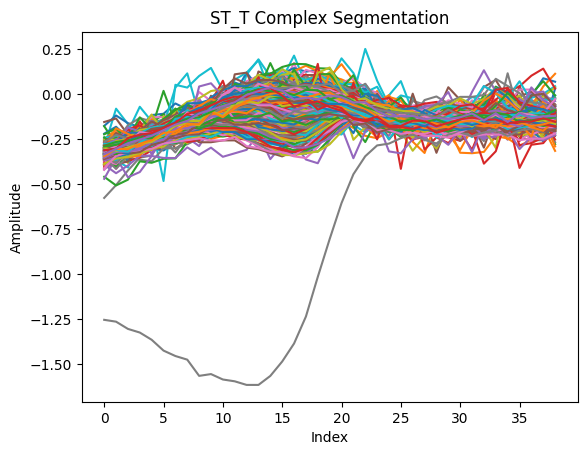

In [ ]:
#print the first complex
plt.plot(ST_T_complexes_transpose)

plt.xlabel('Index')
plt.ylabel('Amplitude')


plt.title('ST_T Complex Segmentation')

plt.show()

### 2.3.- Windowing

In [ ]:
# 3. Windowing (para indicar en que tamaño de ventanas, con cuantos latidos se quiere hacer el análisis)

WindSize = 32      # analizar en bloques de 32 latidos
WindStep = 8       # cada ventana contiene 8 latidos nuevos

ST_T_segments, ST_T_onset_by_segments, _ = heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep)


In [ ]:
#print shape
print(ST_T_segments.shape)             #32(empaquetado), 39 (nº de muestras en cada complejo), 58 (segments)

In [ ]:
#transpose ST_T_complexes

ST_T_segments_transpose = np.transpose(ST_T_segments)

#print the first complex from the first segment
plt.plot(ST_T_segments[0,:,0], color = 'red')

print(ST_T_segments_transpose.shape)
plt.xlabel('T')
plt.ylabel('Amplitude')


plt.title('First ST_T Segment')

plt.show()

In [ ]:
#print all the first segment
plt.plot(ST_T_segments_transpose[0,:,:])

plt.xlabel('Index')
plt.ylabel('Amplitude')


plt.title('ST_T Segment')


plt.show()

### 2.4.- ST-T alignment

In [ ]:
# 4.Alineación de los segmentos ST-T

WindSize = 32
NumbSegments = ST_T_segments.shape[2]

# Step 1: Create an array of zeros to store the aligned ST-T segments
ST_T_segments_aligned = np.zeros((WindSize, ST_T_segments.shape[1], NumbSegments))


In [ ]:
#print shape
print(ST_T_segments_aligned.shape)

In [ ]:
# Step 2: Iterate over each segment
for k in range(NumbSegments):
    # Step 3: Align the ST-T segment using ST_T_alignment function
    aligned_segment = ST_T_alignment(ST_T_segments[:,:,k], ST_T_onset_by_segments[k,:], clean_ecg_noBW, Fs)

    # Step 4: Store the aligned segment in the corresponding position of ST_T_segments_aligned
    ST_T_segments_aligned[:,:,k] = aligned_segment

In [ ]:
#print the first complex from the first segment
plt.plot(ST_T_segments_aligned[0,:,0], color = 'red')

plt.xlabel('Index')
plt.ylabel('Amplitude')


plt.title('First ST_T Segment Aligned')


plt.show()

In [ ]:
#transpose ST_T_segments_aligned

ST_T_segments_aligned_transpose = np.transpose(ST_T_segments_aligned)

#todos los alineados
plt.plot(ST_T_segments_aligned_transpose[0,:,:])


plt.xlabel('Index')
plt.ylabel('Amplitude')


plt.title('ST_T Segment Aligned')


plt.show()

In [ ]:
print(ST_T_segments_transpose.shape)

In [ ]:
#ver diferencia entre ST_T_segments y ST_T_segments_aligned
#deberia ser minima o no haber
plt.figure()
plt.plot(ST_T_segments_aligned[0,:,2], color='red', label='ST_T_segments_aligned')
plt.plot(ST_T_segments[0,:,2], color='blue', label='ST_T_segments')


plt.title('Diference between the first complex of ST_T_segments and ST_T_segments_aligned')
plt.legend()
plt.show()


In [ ]:
#ver diferencia entre ST_T_segments y ST_T_segments_aligned
#deberia ser minima o no haber
plt.figure()
plt.plot(ST_T_segments_aligned_transpose[0,:,:], color='red', label='ST_T_segments_aligned')
plt.plot(ST_T_segments_transpose[0,:,:], color='blue', label='ST_T_segments')

plt.title('Diference between the all complex of ST_T_segments and ST_T_segments_aligned')
plt.show()


### 2.5.- Background Substraction

In [ ]:
# 5. Background Subtraction (restar los latidos de 2 en 2 para quedarnos solamente con la parte alternante si la hay)
##hace la diferencia entre 2 compejos ST_T contiguos.

WindSize = 32
NumbSegments = ST_T_segments_aligned.shape[2]

ST_T_dif = np.zeros_like(ST_T_segments_aligned)




In [ ]:
print(ST_T_dif.shape)

In [ ]:
for k in range(NumbSegments-1):
  ST_T_TensorBacGrElim = background_subtraction(ST_T_segments_aligned[:,:,k], WindSize)

  ST_T_dif[:,:,k] = ST_T_TensorBacGrElim

In [ ]:
plt.figure
plt.plot(ST_T_dif[0,:,0])
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('ST_T Segment After background substraction')
plt.show()

In [ ]:
plt.figure
plt.plot(np.transpose(ST_T_dif[:,:,0]))
plt.show()


In [ ]:
#print the first complex from the first segment
plt.plot(ST_T_dif[0,:,4], color = 'red')
plt.plot(ST_T_dif[1,:,4], color = 'blue')
plt.plot(ST_T_dif[2,:,4], color = 'green')
plt.plot(ST_T_dif[3,:,4], color = 'purple')
plt.show()

# if there is no alternation, nothing comes out
# if the signal has TWA, a ripple would be output.

### 2.6.- Linear Filtering

In [ ]:
##The filter will retain frequencies within the range of 0.3 to 15 Hz, where the alternans is present.
fs = 128
ST_T_dif_filtered = filtering_ST_T_segments(ST_T_dif, fs)

In [ ]:
#print shape
print(ST_T_dif_filtered.shape)

In [ ]:
#print the first complex from the first segment
plt.plot(ST_T_dif_filtered[0,:,0], color = 'red', label='ST_T_dif_filtered')
plt.plot(ST_T_dif[0,:,0], color = 'blue', label='ST_T_dif')

plt.legend()
plt.show()
#smoother

In [ ]:
print(ST_T_dif_filtered.shape)
#print the first segment
plt.plot(np.transpose(ST_T_dif_filtered[:,:,0]))
plt.show()



In [ ]:
print(ST_T_dif_filtered[:,:,0])